In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from utils import *
from utils.helpers import czi_predict_movie
import skimage

In [2]:
torch.cuda.set_device(2)

In [3]:
img_data = Path('/scratch/bpho/datasets/transfer_learning_neuron_002/')
model_path = Path('/scratch/bpho/models')
nb_name = "transfer_learning_neuron_002_unet_mse"

In [20]:
!ls {img_data}/lr_up/train/

'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_000.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_001.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_002.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_003.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_004.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_005.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_006.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_007.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_008.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_009.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_010.tif'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01_00_000_011.tif'
'high res airyscan 300 time points 2 raw

In [4]:
def get_src(size=128):
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None, max_zoom=8.):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_resize_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [22]:
!ls {img_data}

hr  lr	lr_up


In [23]:
bs = 64
size = 128
data = get_data(bs, size, max_zoom=4)
data

/scratch/bpho/datasets/transfer_learning_neuron_002/lr_up


ImageDataBunch;

Train: LabelList (2400 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/transfer_learning_neuron_002/lr_up;

Valid: LabelList (1410 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/transfer_learning_neuron_002/lr_up;

Test: None

In [19]:
#fn = list((img_data/'hr'/'train').glob('*.tif'))[0]
#PIL.Image.open(fn)

In [5]:
feat_loss = F.mse_loss

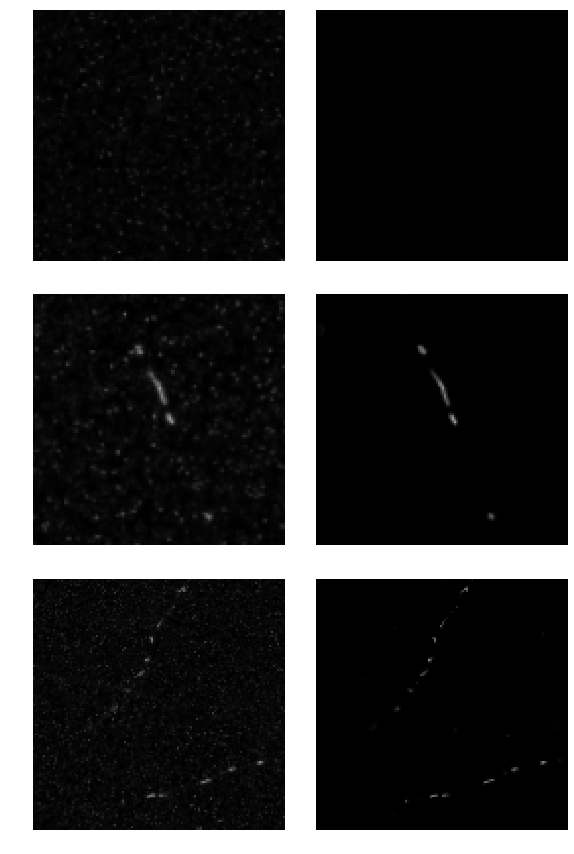

In [25]:
data.show_batch(3)

In [30]:
arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load('synth_newcrap_001_unet_mse.7')
gc.collect()

0

In [6]:
learn.lr_find()
learn.recorder.plot()

NameError: name 'learn' is not defined

In [8]:
lr = 5e-4

In [9]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start,
                        callbacks=[SaveModelCallback(learn, name=save_name)])
    #learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [10]:
do_fit(f'{nb_name}.0', lr, cycle_len=100)

NameError: name 'learn' is not defined

In [35]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000287,0.000897,0.000897,0.939387,30.496050,01:05
1,0.000295,0.000895,0.000895,0.939635,30.507660,01:05
2,0.000295,0.000913,0.000913,0.939147,30.419800,01:05
3,0.000292,0.000908,0.000908,0.939692,30.445007,01:06
4,0.000287,0.000924,0.000924,0.939708,30.368324,01:04
5,0.000290,0.000888,0.000888,0.939790,30.541199,01:05
6,0.000287,0.000899,0.000899,0.939717,30.487112,01:05
7,0.000289,0.000902,0.000902,0.940010,30.470446,01:05
8,0.000289,0.000909,0.000909,0.939752,30.438217,01:05
9,0.000288,0.000891,0.000891,0.940265,30.524858,01:05


Better model found at epoch 0 with val_loss value: 0.0008969989139586687.
Better model found at epoch 1 with val_loss value: 0.0008945910376496613.
Better model found at epoch 5 with val_loss value: 0.0008875795174390078.


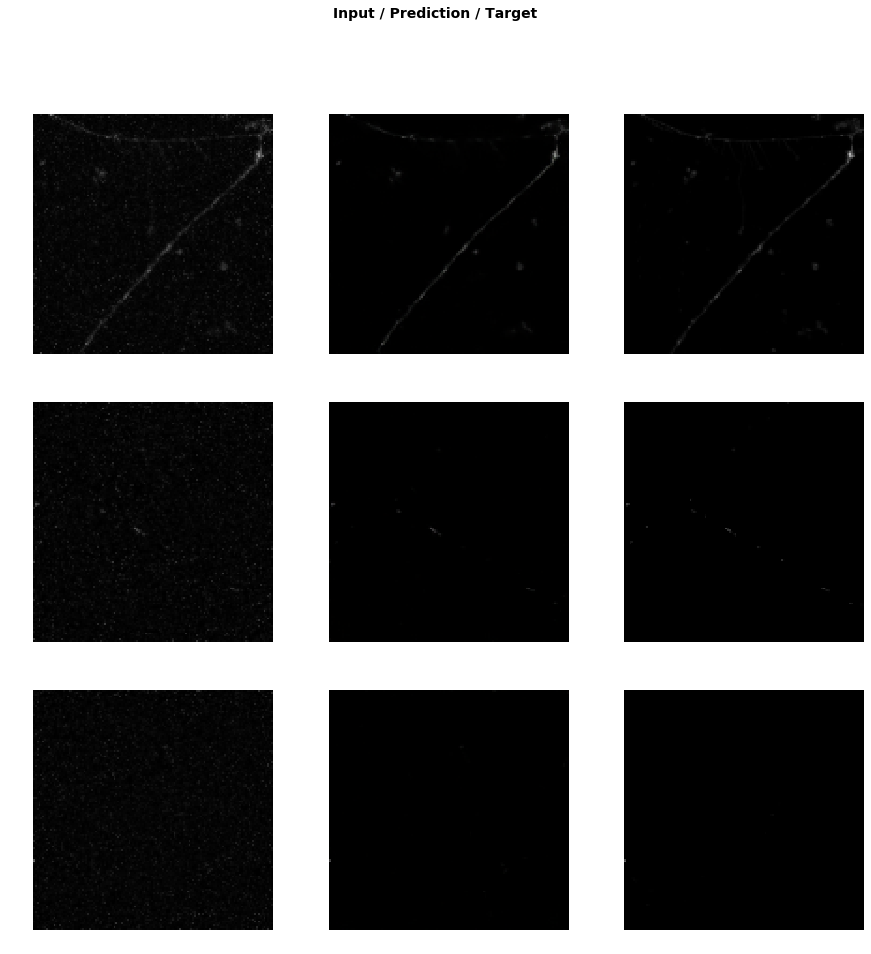

In [36]:
do_fit(f'{nb_name}.1', slice(1e-5,lr), cycle_len=100)

In [11]:
bs = 8
size = 256
data = get_data(bs, size, max_zoom=4.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics,# callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True, 
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.1')
gc.collect()


/scratch/bpho/datasets/transfer_learning_neuron_002/lr_up


0

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001618,0.001536,0.001536,0.908601,28.481552,01:21
1,0.001529,0.001403,0.001403,0.911602,28.889292,01:16
2,0.001364,0.001385,0.001385,0.915170,28.973665,01:16
3,0.001321,0.001319,0.001319,0.918707,29.204727,01:16
4,0.001127,0.001310,0.001310,0.921221,29.263966,01:16
5,0.000977,0.001288,0.001288,0.921952,29.333244,01:16
6,0.000936,0.001301,0.001301,0.923950,29.316633,01:16
7,0.000817,0.001262,0.001262,0.924657,29.445265,01:16
8,0.000749,0.001245,0.001245,0.926186,29.512594,01:17
9,0.000662,0.001232,0.001232,0.926905,29.557835,01:16


Better model found at epoch 0 with val_loss value: 0.001535958144813776.
Better model found at epoch 1 with val_loss value: 0.0014030421152710915.
Better model found at epoch 2 with val_loss value: 0.0013850523391738534.
Better model found at epoch 3 with val_loss value: 0.001318721566349268.
Better model found at epoch 4 with val_loss value: 0.0013100778451189399.
Better model found at epoch 5 with val_loss value: 0.0012881068978458643.
Better model found at epoch 7 with val_loss value: 0.0012616573367267847.
Better model found at epoch 8 with val_loss value: 0.0012447636108845472.
Better model found at epoch 9 with val_loss value: 0.0012321496615186334.
Better model found at epoch 10 with val_loss value: 0.0011837165802717209.
Better model found at epoch 14 with val_loss value: 0.0011754796141758561.
Better model found at epoch 15 with val_loss value: 0.0011605625040829182.


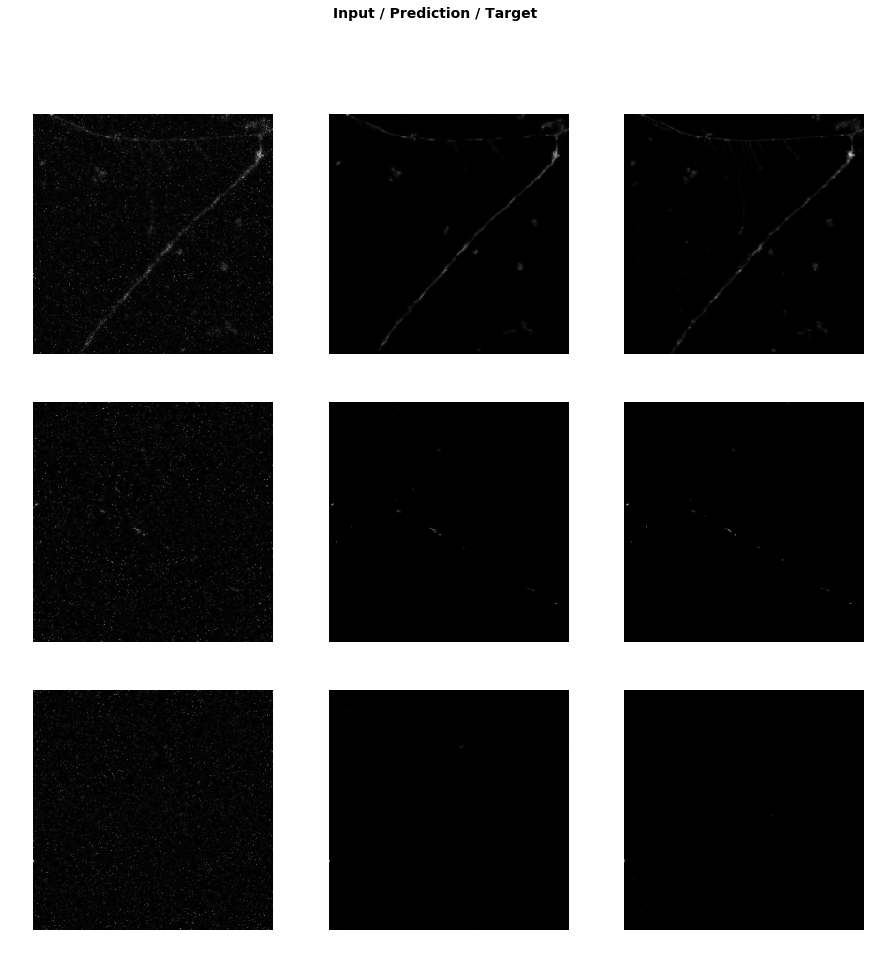

In [12]:
do_fit(f'{nb_name}.2', lr/100, cycle_len=100)

In [13]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000547,0.001176,0.001176,0.932782,29.763756,01:20
1,0.000568,0.001187,0.001187,0.933116,29.724983,01:21
2,0.000532,0.001188,0.001188,0.933520,29.718328,01:21
3,0.000531,0.001217,0.001217,0.933147,29.619761,01:21
4,0.000517,0.001203,0.001203,0.933901,29.666237,01:20
5,0.000531,0.001199,0.001199,0.934027,29.679203,01:22
6,0.000507,0.001217,0.001217,0.933652,29.618429,01:22
7,0.000498,0.001209,0.001209,0.934263,29.642656,01:23
8,0.000514,0.001206,0.001206,0.934273,29.652538,01:23
9,0.000530,0.001238,0.001238,0.933912,29.551781,01:22


Better model found at epoch 0 with val_loss value: 0.001175964018329978.
Better model found at epoch 45 with val_loss value: 0.0011690660612657666.
Better model found at epoch 47 with val_loss value: 0.0011516630183905363.
Better model found at epoch 60 with val_loss value: 0.0011378963245078921.
Better model found at epoch 68 with val_loss value: 0.0011200412409380078.
Better model found at epoch 85 with val_loss value: 0.0011167852208018303.
Better model found at epoch 90 with val_loss value: 0.0010995211778208613.


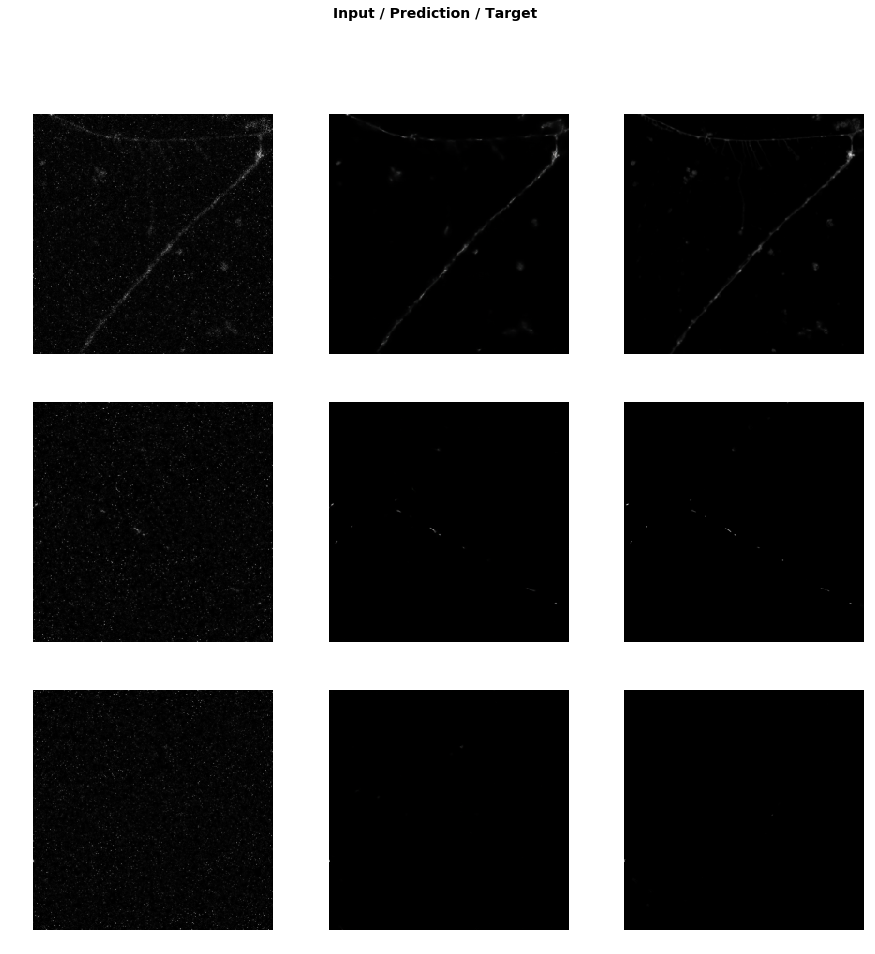

In [14]:
do_fit(f'{nb_name}.3', slice(1e-5,lr/10), cycle_len=100)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [15]:
bs = 2
size = 512
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.3')
gc.collect()

/scratch/bpho/datasets/transfer_learning_neuron_002/lr_up


0

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000608,0.001567,0.001567,0.939607,30.016886,04:06
1,0.000638,0.001532,0.001532,0.944185,30.163536,04:02
2,0.000530,0.001503,0.001503,0.945910,30.239077,04:02
3,0.000596,0.001497,0.001497,0.946965,30.247564,04:02
4,0.000572,0.001502,0.001502,0.946967,30.257906,04:02
5,0.000588,0.001521,0.001521,0.947132,30.214077,04:02
6,0.000589,0.001503,0.001503,0.946815,30.218138,04:02
7,0.000551,0.001515,0.001515,0.947332,30.238678,04:03
8,0.000598,0.001480,0.001480,0.947526,30.302959,04:02
9,0.000558,0.001517,0.001517,0.947280,30.225296,04:02


Better model found at epoch 0 with val_loss value: 0.0015672392910346389.
Better model found at epoch 1 with val_loss value: 0.0015322116669267416.
Better model found at epoch 2 with val_loss value: 0.0015029179630801082.
Better model found at epoch 3 with val_loss value: 0.0014968466712161899.
Better model found at epoch 8 with val_loss value: 0.0014796728501096368.
Better model found at epoch 17 with val_loss value: 0.0014785140519961715.
Better model found at epoch 19 with val_loss value: 0.0014632466481998563.
Better model found at epoch 21 with val_loss value: 0.001462613116018474.
Better model found at epoch 22 with val_loss value: 0.0014617323176935315.
Better model found at epoch 24 with val_loss value: 0.0014469415182247758.
Better model found at epoch 27 with val_loss value: 0.0014463005354627967.
Better model found at epoch 29 with val_loss value: 0.0014462595572695136.
Better model found at epoch 30 with val_loss value: 0.0014427404385060072.
Better model found at epoch 34 

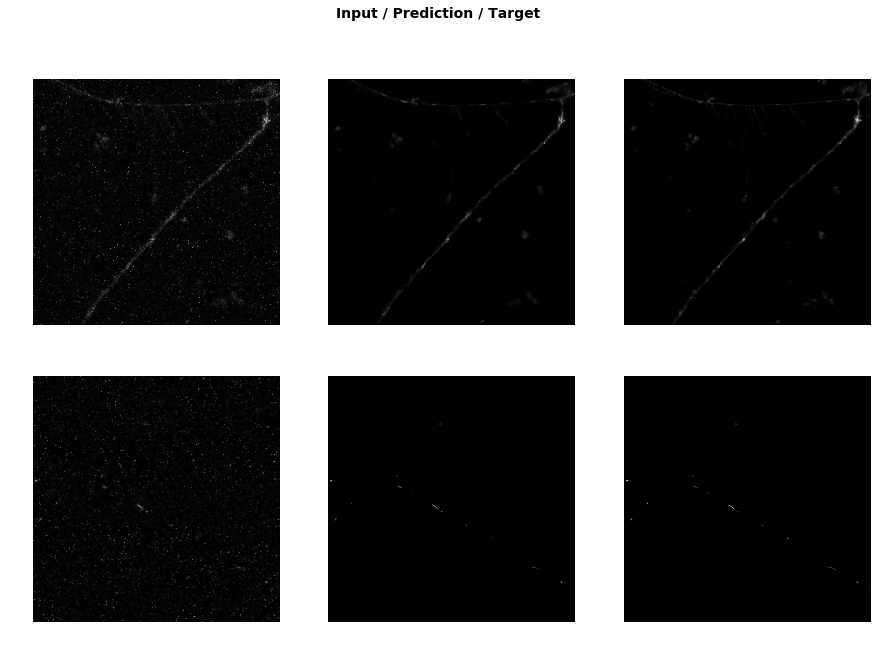

In [16]:
do_fit(f'{nb_name}.4', lr/100, cycle_len=100)

In [17]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000513,0.001353,0.001353,0.950814,30.668091,04:11
1,0.000513,0.001359,0.001359,0.950708,30.651917,04:11
2,0.000535,0.001360,0.001360,0.950689,30.647530,04:11
3,0.000525,0.001354,0.001354,0.950703,30.663290,04:11
4,0.000500,0.001344,0.001344,0.950582,30.664600,04:11
5,0.000515,0.001363,0.001363,0.950705,30.648579,04:11
6,0.000503,0.001330,0.001330,0.950404,30.699600,04:11
7,0.000545,0.001347,0.001347,0.950810,30.681299,04:11
8,0.000560,0.001350,0.001350,0.950898,30.679724,04:11
9,0.000549,0.001352,0.001352,0.950903,30.663910,04:11


Better model found at epoch 0 with val_loss value: 0.0013526639668270946.
Better model found at epoch 4 with val_loss value: 0.0013436696026474237.
Better model found at epoch 6 with val_loss value: 0.0013302677543833852.
Better model found at epoch 25 with val_loss value: 0.0013200545217841864.
Better model found at epoch 37 with val_loss value: 0.001310398569330573.


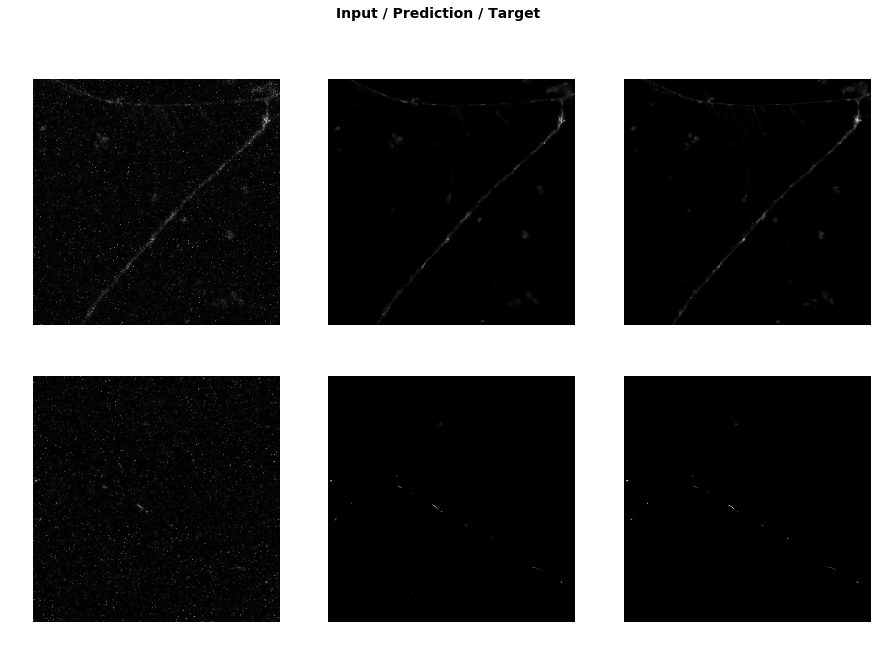

In [18]:
do_fit(f'{nb_name}.5', slice(1e-6,lr/100), cycle_len=50)

In [19]:
bs = 1
size = 1024
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.5')

/scratch/bpho/datasets/transfer_learning_neuron_002/lr_up


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000669,0.001669,0.001669,0.945791,30.650261,19:02
1,0.000637,0.001598,0.001598,0.949398,30.857580,18:56
2,0.000723,0.001597,0.001597,0.949379,30.836517,18:57
3,0.000657,0.001590,0.001590,0.949816,30.884237,18:57
4,0.000811,0.001589,0.001589,0.949775,30.842497,18:57
5,0.000612,0.001602,0.001602,0.950363,30.904860,18:56
6,0.000706,0.001589,0.001589,0.949984,30.788641,18:56
7,0.000602,0.001616,0.001616,0.950437,30.895983,18:57
8,0.000627,0.001590,0.001590,0.950713,30.950811,18:56
9,0.000567,0.001590,0.001590,0.949689,30.797615,18:56


Better model found at epoch 0 with val_loss value: 0.0016690694028511643.
Better model found at epoch 1 with val_loss value: 0.001597938477061689.
Better model found at epoch 2 with val_loss value: 0.0015972418477758765.
Better model found at epoch 3 with val_loss value: 0.0015897548291832209.
Better model found at epoch 4 with val_loss value: 0.0015885498141869903.


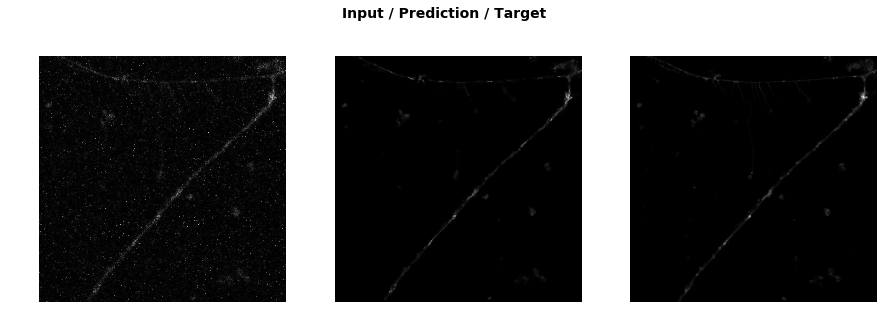

In [20]:
do_fit(f'{nb_name}.6', lr/100, cycle_len=10)

In [21]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000664,0.001577,0.001577,0.949437,30.831621,19:23
1,0.000611,0.001588,0.001588,0.950588,30.934128,19:23
2,0.000634,0.001592,0.001592,0.950363,30.919897,19:23
3,0.000639,0.001606,0.001606,0.950024,30.866961,19:23
4,0.000643,0.001617,0.001617,0.950575,30.912663,19:23
5,0.000623,0.001614,0.001614,0.948688,30.655210,19:23
6,0.000590,0.001609,0.001609,0.950646,30.902718,19:23
7,0.000570,0.001577,0.001577,0.950274,30.908804,19:23
8,0.000666,0.001585,0.001585,0.950986,30.948483,19:23
9,0.000662,0.001596,0.001596,0.951210,30.952856,19:23


Better model found at epoch 0 with val_loss value: 0.001577159040607512.


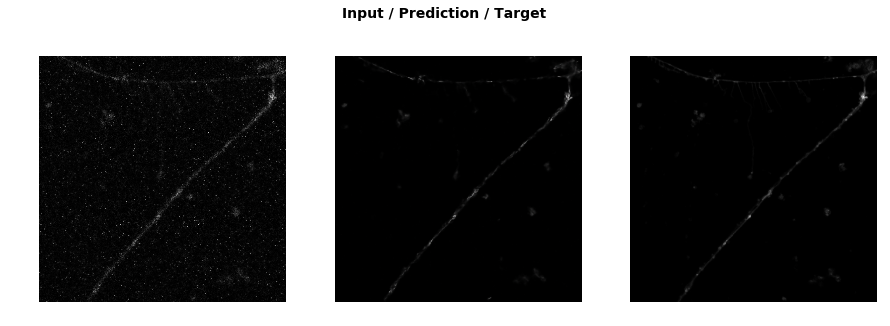

In [22]:
do_fit(f'{nb_name}.7', slice(1e-6,lr/100), cycle_len=10)

In [23]:
print('cool')

cool


# Test

In [33]:
!ls /scratch/bpho/models/{nb_name}*

/scratch/bpho/models/synth_newcrap_001_unet_mse.0.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.1.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.2.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.3.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.4.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.5.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.6.pth
/scratch/bpho/models/synth_newcrap_001_unet_mse.7.pth


In [24]:
#test_path = Path('/home/bpho/Documents/test/neuron_new_data/')
test_path = Path('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/')
!ls {test_path}

'high res 125 time points 1.czi'
'high res airyscan 300 time points 11 raw lots of good mitos after refocusing-Airyscan Processing-01.czi'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01.czi'
'high res airyscan 300 time points 3 raw-Airyscan Processing-02.czi'
'high res airyscan 300 time points 4 raw-Airyscan Processing-03.czi'
'high res airyscan 300 time points 5 raw-Airyscan Processing-04.czi'
'high res airyscan 300 time points 6 raw-Airyscan Processing-05.czi'
'high res airyscan 300 time points 7 raw-Airyscan Processing-06.czi'
'high res airyscan 300 time points 8 raw-Airyscan Processing-07.czi'
'low res 1200 time points 10 high signal.czi'
'low res 1200 time points 11 high signal.czi'
'low res 1200 time points 9 high signal.czi'
'low res 1500 time points 7.czi'
'low res 1500 time points 8.czi'
'low res 1500 time points 8 redo best.czi'
'low res 2000 time points 1.czi'
'low res 300 time points 2.czi'
'low res 300 time points 3.czi'
'low res 300 time points 4.czi'
'lo

In [26]:
#movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))
movie_files = list(test_path.glob('low*.czi'))
movie_files

[PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 8.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 300 time points 2.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 7.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 2000 time points 1.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1200 time points 10 high signal.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 300 time points 3.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1200 time points 9 high signal.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 8 redo best.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_

In [40]:
test_files = list(test_path.glob('*.tif'))
test_files

[PosixPath('/home/bpho/Documents/test/3ViewBrain_350x350/3ViewBrain_50x50x80nm-px-1_350x350.tif')]

In [27]:
fn = movie_files[0]
len(movie_files)

12

In [28]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]

            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [36]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            #preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)
            pred_img_out = pred_out+f'_slice{t}.tif'
            skimage.io.imsave(pred_img_out,pred[0,:,:,:])
            
        #all_y = np.concatenate(preds)
        #print(all_y.shape)
        #imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        #all_y = np.concatenate(origs)
        #print(all_y.shape)
        #imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


In [37]:
bs=1
size=380*4
scale = 4

data = get_data(bs, size, tile_size=128)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()
learn = learn.load(f'{nb_name}.7').to_fp16()


/scratch/bpho/datasets/transfer_learning_neuron_002/lr_up


In [31]:
def tif_predict_movie(learn, tif_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
        data = libtiff.TiffFile(tif_in)
        data = data.get_tiff_array()
        depths = data.shape[0]
        img_max = None
        preds = []
        origs = []
        for depth in progress_bar(list(range(depths))):
            img = data[depth].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            pred_img_out = pred_out+f'_slice{depth}.tif'
            skimage.io.imsave(pred_img_out,pred[0,:,:,:])
            
            #preds.append(pred)
            #orig = (img[None]*255).astype(np.uint8)
            #origs.append(orig)

#        all_y = np.concatenate(preds)
        #print(all_y.shape)
#        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
#        all_y = np.concatenate(origs)
        #print(all_y.shape)
#        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)

In [46]:
import libtiff
for fn in test_files:
    pred_name = f'{fn.stem}_pred'
    orig_name = f'{fn.stem}_orig.tif'
    tif_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [ ]:
#learn.export(model_path/'paired_001_unet.8.pkl')
#learn = load_learner(model_path, 'paired_001_unet.8.pkl')

In [38]:
for fn in movie_files:
    #pred_name = f'{fn.stem}_pred.tif'
    pred_name = f'{fn.stem}_pred'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

RuntimeError: CUDA out of memory. Tried to allocate 438.00 MiB (GPU 2; 10.73 GiB total capacity; 9.07 GiB already allocated; 360.69 MiB free; 568.30 MiB cached)

In [ ]:
learn.pred_batch()